# Problem 1

For this exercise we will follow the discussion of the energy levels in Chapter 9.2.2.
The calculation of the eigenfunctions uses Numerov's method (Chapter 9.2.1).

## (a) Energy Levels in 1-D Quantum Well

In [1]:
# imports 
import numpy as np
import matplotlib.pylab as plt
import copy

We start by making the wavefunction tools. The aim is to have this be the only code that touches quantum mechanics. The rest should use the values generated by these functions to find the allowed energy levels. 

In [2]:
# Define a function to plot the potential
def potential(radius, depth, step_size): 
    
    # initialize a well-less potential
    # I look at an area 8 times larger than the radius
    position = np.arange(-4 * radius, 4 * radius, step_size)
    pot_energy = np.zeros(len(position))
    
    # set the potential and width at the proper points 
    pot_energy[abs(position) <= radius] = depth
        
    return position, pot_energy

# Implement the Numerov method (eqn. 9.20)

def numerov(position, pot_energy, lev_energy, left = False):
    
    # 'left' will tell the code to start from the RIGHT side,
    # and MOVE LEFT. 
    
    # calculate the match point from where the potential 
    # changes from 0 on the right. 
    match = np.nonzero(pot_energy)[0][-1]
    
    # calculate step size from position
    h = position[1] - position[0]
    
    ### calculate k^2 (eqn 9.12) ###
    # I initialize k_vec to have value E
    k_vec = np.ones(len(position)) * lev_energy

    # The well shape is already encoded into v_0
    # I take advantage of this to ignore the piecewise function
    k_vec += pot_energy
    
    # scale appropriately to realistic units (eqn 9.8)
    k_vec *= 0.0483
       
    ### Impliment the Numerov method (eqn. 9.20)###
    # Initlaize Psi
    psi = np.zeros(len(position), float)

    # eqn. 9.20
    if not left:
        # move TO THE RIGHT
        # Manually increment the probability. Otherwise, we 
        # would permanently be stuck at 0
        psi[1] = 0.00001
        for ii in range(1, match): 
            psi[ii + 1] = 2 * (1 - ((5/12) * h**2 * k_vec[ii])) * psi[ii]
            psi[ii + 1] -= (1 + (((h**2)/12) * k_vec[ii - 1])) * psi[ii - 1]
            psi[ii + 1] /= 1 + ((h**2 * k_vec[ii + 1])/12)
        
        # the value at the matching point
        match_value = psi[match]

    
    elif left: 
        # move TO THE LEFT
        # Manually increment the second to last position. 
        psi[-2] = 0.00001
        
        # This range is a bit complicated. It goes backwards, and
        # the -2 / + 1 have to do with inclusuive and exclusive limits, and
        # the index ranging from 0 to len() - 1. 
        for ii in range(len(position) - 2, match, -1): 
            psi[ii - 1] = 2 * (1 - ((5/12) * h**2 * k_vec[ii])) * psi[ii]
            psi[ii - 1] -= (1 + (((h**2)/12) * k_vec[ii + 1])) * psi[ii + 1]
            psi[ii - 1] /= 1 + ((h**2 * k_vec[ii - 1])/12)    
    
    return psi, match

# Find the log difference in energies 
def energy_difference(position, pot_energy, lev_guess): 
    h = position[1] - position[0]
    psi_right, match = numerov(position, pot_energy, lev_guess, left = False)
    psi_left, match  = numerov(position, pot_energy, lev_guess, left = True)
    
    # use backward differencing on the wavefunction extending from the left 
    psi_right_prime = (psi_right[match] - psi_right[match - 1])/h
    psi_right_normal= psi_right[match]
    psi_right_diff = psi_right_prime / psi_right_normal
    
    # use forward differencing on the wavefunction extending from the right
    psi_left_prime  = (psi_left[match + 1] - psi_left[match])/h
    psi_left_normal = psi_left[match]
    psi_left_diff = psi_left_prime / psi_left_normal

    # calculate the difference in logarithmic derivatives    
    log_diff = (psi_right_diff - psi_left_diff) / (psi_left_diff + psi_right_diff)
    
    # Reject cases where the second derivative is discontinuous. 
    # It seems that incorrect wavefunctions tend to form cusps, and correct wavefunctions do not. 
    # Check for cusps by making sure that the value of the derivative is the same. 
    if psi_right_diff * psi_left_diff < 0: 
        sign_diff = True
    else: 
        sign_diff = False
     
    return log_diff, sign_diff


Now we will begin work on the bisection algorithm. 
This algorithm finds the energies that give zeros for the `energy_difference`.

In [3]:
# Find all allowed energies in the well
def energy_finder(position_values, potential_values, coarse_step, error_tol, max_iterations): 
    
    # Use the minimum and maximum energy as bounds
    e_min = -max(potential_values)
    e_max = 0
    
    # Perform an evenly spaced search to seed our bisection algorithm
    search_energies = np.arange(e_min, e_max, coarse_step)
    search_difference = np.empty(len(search_energies))
    
    for ii in range(len(search_energies)): 
        search_difference[ii], unused = energy_difference(position_values, potential_values, search_energies[ii])
    
    # Determine where our difference changes sign 
    sign_flips = np.where((np.diff(np.sign(search_difference)) != 0) == True)
    energy_bounds = []
    
    for ii in sign_flips[0]:
        energy_bounds.append([search_energies[ii], search_energies[ii + 1]])
        
    # We now have an array of bounds over which to search for bound states 
    # Use the bisection algorithm to hone in on the correct wavefunctions
    final_energies = []
    
    #loop through all the energy bounds that we found. 
    for ii in energy_bounds: 
        
        # Find upper, lower, and middle energies at which to evaluate. 
        lower_bound = ii[0]
        upper_bound = ii[1]
        middle = (lower_bound + upper_bound)/2
        
        # Set our error to be larger than our error tolerance
        error = np.nextafter(error_tol, error_tol + 1)
        
        # Start a counter of iterations
        it_count = 1
        
        while error > error_tol and it_count <= max_iterations: 
            energy_lower, unused  = energy_difference(position_values, potential_values, lower_bound)
            energy_upper, unused  = energy_difference(position_values, potential_values, upper_bound)
            energy_middle, unused = energy_difference(position_values, potential_values, middle)
            
            # Is the energy between the middle and upper bound?
            if energy_middle * energy_upper < 0: 
                lower_bound = middle
            
            else: 
                upper_bound = middle
            
            error = abs(energy_upper - energy_lower)
            middle = (lower_bound + upper_bound)/2
            
            it_count += 1
            
            if it_count > max_iterations: 
                print('Maximum iterations performed. Keeping: ', middle)
            
        final_energies.append(middle)
        
    # Cannot have energies with a discontinuous first derivative
    to_pop = []
    # Loop through all of our energies, looking for cusps 
    for ii in range(len(final_energies)): 
        unused, sign_diff = energy_difference(position_values, potential_values, final_energies[ii])
        
        # If a cusp is found, make note of it. 
        if sign_diff: 
            to_pop.append(ii)
    # Remove all energies that generate cusps         
    for ii in to_pop[::-1]: 
        final_energies.pop(ii)
        
    return final_energies      
        

We now have all of the framework in place to work to answer part (a). 

In [6]:
x_values, y_values = potential(2, 83, 0.04)
bound_energies = energy_finder(x_values, y_values, 2, 0.001, 100)

string = 'The bound energies are: '
print_bound = ()
for ii in bound_energies:
    if ii == bound_energies[-1]: 
        to_append = 'and %.3f MeV.'
    else: 
        to_append = '%.3f, '
    string += to_append
    #print_bound.append(ii)
    
print(string % tuple(bound_energies))

Maximum iterations performed. Keeping:  -69.94737268069144
Maximum iterations performed. Keeping:  -30.78970040581826
The bound energies are: -74.877, -51.139, and -15.408 MeV.


So, we appear to have three bound states for this well. Interestingly, we see that the bisection algorithm found two energies which are not displayed in the final list of bound energies. This is because those energies correspond to functions with cusps, which are not allowed.

# (b) Plotting Results

We will plot the eigenfunctions and energies in this part.

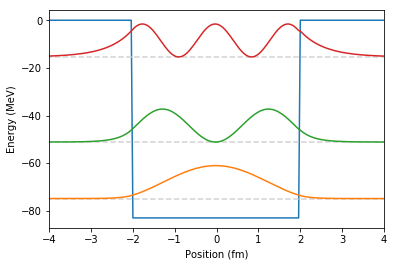

In [9]:
def master_plot(energies, positions, pot_energy): 
    
    # Plot the potential 
    plt.plot(positions, (pot_energy * -1))
    
    match = np.nonzero(pot_energy)[0][-1]
    
    # Loop through all of our bound state energies
    for ii in energies: 
        # Generate our left and right wavefunctions
        psi_right, match_right = numerov(positions, pot_energy, ii, False)
        psi_left, match_left = numerov(positions, pot_energy, ii,  True)
        
        # Now add thse together. Zero one at the matching point
        # so we don't get a spike. 
        psi_left[match] = 0
        psi_tot = (psi_right) + (psi_left)
        
        # Square the wavefunction to get the probability
        psi_tot = psi_tot**2
        
        # Set the maximum height to 1
        psi_tot /= max(psi_tot)
        
        # Scale to be an appropriate portion of the well height
        psi_tot *= max(pot_energy)/(2 * len(energies))
        
        # Move vertically to proper energy
        psi_tot += ii
        
        # Plot the probability, along with an energy line
        
        energy_line = np.ones(len(positions)) * ii
        plt.plot(positions, energy_line, '--', color = '#D3D3D3')
        plt.plot(positions, psi_tot)
        
        
master_plot(bound_energies, x_values, y_values)

# add graph decorations 
plt.xlim([-4, 4])
plt.xlabel('Position (fm)')
plt.ylabel('Energy (MeV)')
plt.show()

As expected, the longest wavelength eigenfunction corresponds to the lowest energy (ground state energy).
The next two energies correspond to eigenfunctions with more nodes.

By the way, these functions have been displaced vertically to associate them with their energies.
Of course the functions are really at the same level, but in any case it doesn't make a difference.
Overlaying the eigenfunction amplitudes on the energy scale is completely arbitrary.

## (c) Effect of Changing Well Size

Now we can investigate the energy levels for a well having double the radius: 4 fm instead of 2 fm.

Maximum iterations performed. Keeping:  -79.77230433706555
Maximum iterations performed. Keeping:  -70.08922259387117
Maximum iterations performed. Keeping:  -53.95077248148324
Maximum iterations performed. Keeping:  -31.35699358666991
Maximum iterations performed. Keeping:  -2.308089472718869
The bound energies are: -80.481, -72.952, -60.511, -43.401, -22.278, and -0.614 MeV.


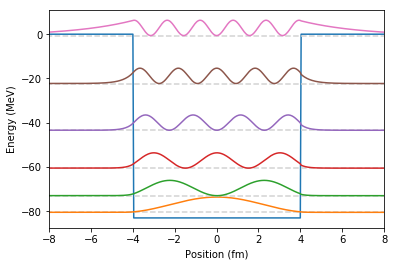

In [10]:
x_values, y_values = potential(4, 83, 0.04)
bound_energies = energy_finder(x_values, y_values, 0.5, 0.001, 100)

string = 'The bound energies are: '
print_bound = ()
for ii in bound_energies:
    if ii == bound_energies[-1]: 
        to_append = 'and %.3f MeV.'
    else: 
        to_append = '%.3f, '
    string += to_append
    #print_bound.append(ii)
    
print(string % tuple(bound_energies))

master_plot(bound_energies, x_values, y_values)
 
plt.xlim([-8, 8])
plt.xlabel('Position (fm)')
plt.ylabel('Energy (MeV)')
plt.show() 

We can see that there are twice as many bound energies when we double the width of the well. 

As as a further test of our code, let's make the well twice as deep (166 MeV) and twice as wide (4 fm). 

Maximum iterations performed. Keeping:  -165.19745406809307
Maximum iterations performed. Keeping:  -162.7898163891233
Maximum iterations performed. Keeping:  -158.77708732141866
Maximum iterations performed. Keeping:  -153.15926748949846
Maximum iterations performed. Keeping:  -145.9363578269569
Maximum iterations performed. Keeping:  -137.1083596408402
Maximum iterations performed. Keeping:  -126.6752747036522
Maximum iterations performed. Keeping:  -114.63710538467438
Maximum iterations performed. Keeping:  -100.9938548439755
Maximum iterations performed. Keeping:  -85.74552734077625
Maximum iterations performed. Keeping:  -68.89212878561435
Maximum iterations performed. Keeping:  -50.433667930605495
Maximum iterations performed. Keeping:  -30.370159838340257
Maximum iterations performed. Keeping:  -8.7016454557522
The bound energies are: -165.268, -163.073, -159.416, -154.299, -147.725, -139.697, -130.223, -119.312, -106.974, -93.230, -78.112, -61.662, -43.970, -25.221, and -6.094 

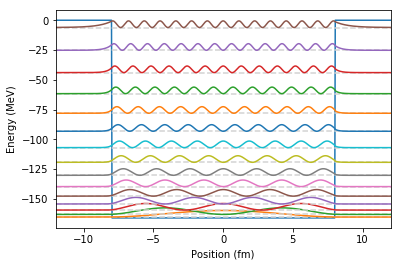

In [11]:
x_values, y_values = potential(8, 83*2, 0.04)
bound_energies = energy_finder(x_values, y_values, 0.1, 0.001, 100)

string = 'The bound energies are: '
print_bound = ()
for ii in bound_energies:
    if ii == bound_energies[-1]: 
        to_append = 'and %.3f MeV.'
    else: 
        to_append = '%.3f, '
    string += to_append
    #print_bound.append(ii)
    
print(string % tuple(bound_energies))

master_plot(bound_energies, x_values, y_values)

# Some fine tuning... 
plt.xlim([-12, 12])
plt.xlabel('Position (fm)')
plt.ylabel('Energy (MeV)')
plt.show() 

# Problem 2

## (a) Pythagorean problem

We need to include all of the gravitational forces between the three objects.
For example, the second-order differential equations for mass A are 

$$\begin{align}
\ddot{x}_A &= -G m_B \frac{x_A-x_B}{d_{AB}^3} - G m_C \frac{x_A-x_C}{d_{AC}^3} \\
\ddot{y}_A &= -G m_B \frac{y_A-y_B}{d_{AB}^3} - G m_C \frac{y_A-y_C}{d_{AC}^3} \\
\end{align}$$

We define a **state** of the satellite for our program
$S = (x_A, v_{xA}, y_A, v_{yA}, x_B, v_{xB}, y_B, v_{yB}, x_C, v_{xC}, y_C, v_{yC})$, so that we can write a system of 12 first-order differential equations.
The first four look like this:

$$\begin{align}
\dot{x_A} &= v_{xA} \\
\dot{v}_{xA} &= -G m_B \frac{x_A-x_B}{d_{AB}^3} - G m_C \frac{x_A-x_C}{d_{AC}^3} \\
\dot{y} &= v_{yA} \\
\dot{v}_{yA} &= -G m_B \frac{y_A-y_B}{d_{AB}^3} - G m_C \frac{y_A-y_C}{d_{AC}^3} \\
\end{align}$$

We will use the Python libraries to integrate the system of ODEs.

<IPython.core.display.Javascript object>


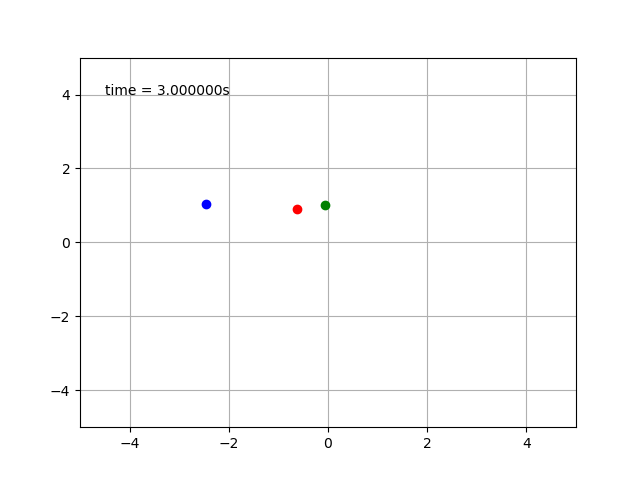

In [15]:
% matplotlib notebook

import numpy as np
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 1.
mA = 3
mB = 4
mC = 5

def derivs(state, t):
    xA = state[0]
    yA = state[2]
    xB = state[4]
    yB = state[6]
    xC = state[8]
    yC = state[10]
    out = np.zeros_like(state)
    d_AB = np.sqrt(pow(xA-xB, 2) + pow(yA-yB, 2))
    d_AC = np.sqrt(pow(xA-xC, 2) + pow(yA-yC, 2))
    d_BC = np.sqrt(pow(xB-xC, 2) + pow(yB-yC, 2))
    
    out[0] = state[1]
    out[1] = -G*mB*(xA-xB)/pow(d_AB,3) - G*mC*(xA-xC)/pow(d_AC,3)
    out[2] = state[3]
    out[3] = -G*mB*(yA-yB)/pow(d_AB,3) - G*mC*(yA-yC)/pow(d_AC,3)
    out[4] = state[5]
    out[5] = -G*mA*(xB-xA)/pow(d_AB,3) - G*mC*(xB-xC)/pow(d_BC,3)
    out[6] = state[7]
    out[7] = -G*mA*(yB-yA)/pow(d_AB,3) - G*mC*(yB-yC)/pow(d_BC,3)
    out[8] = state[9]
    out[9] = -G*mA*(xC-xA)/pow(d_AC,3) - G*mB*(xC-xB)/pow(d_BC,3)
    out[10] = state[11]
    out[11] = -G*mA*(yC-yA)/pow(d_AC,3) - G*mB*(yC-yB)/pow(d_BC,3)
    
    return out

# create a time array
dt = 0.1 # seconds
time_interval = np.arange(0.0, 10.0, dt)

# state with 12 elements of satellite motion: (x, v_x, y, v_y) * 3 bodies
state = (0., 0., 4., 0., -3., 0., 0., 0., 0., 0., 0., 0.)

object_positions = integrate.odeint(derivs, state, time_interval)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-5., 5.), ylim=(-5., 5.))
ax.grid()

markerA, = ax.plot([], [], 'ro-')
markerB, = ax.plot([], [], 'bo-')
markerC, = ax.plot([], [], 'go-')
time_template = 'time = %fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    markerA.set_data([], [])
    markerB.set_data([], [])
    markerC.set_data([], [])
    time_text.set_text('')
    return markerA, markerB, markerC, time_text

def animate(i):
    markerA.set_data(object_positions[i,0], object_positions[i,2])
    markerB.set_data(object_positions[i,4], object_positions[i,6])
    markerC.set_data(object_positions[i,8], object_positions[i,10])
    time_text.set_text(time_template % (i*dt))
    return markerA, markerB, markerC, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(time_interval)),
                                         interval=200, blit=True, init_func=init)

## (b) Stable 3-body orbit

We use the following initial conditions with $G=1$ and $m_A = m_B = m_C = 1$.
These values come from the paper in [Annals of Mathematics 152: 881-901](http://www.jstor.org/stable/2661357).

$$
\begin{array}
\text{Mass} & x & y & v_x & v_y \\
A & 0.97000436 & 0.93240737/2 & -0.24308753 & 0.86473146/2 \\
B & -0.97000436 & 0.93240737/2 & 0.24308753 & 0.86473146/2 \\
C & 0.0 & -0.93240737 & 0.0 & -0.86473146 \\
\end{array}
$$

<IPython.core.display.Javascript object>


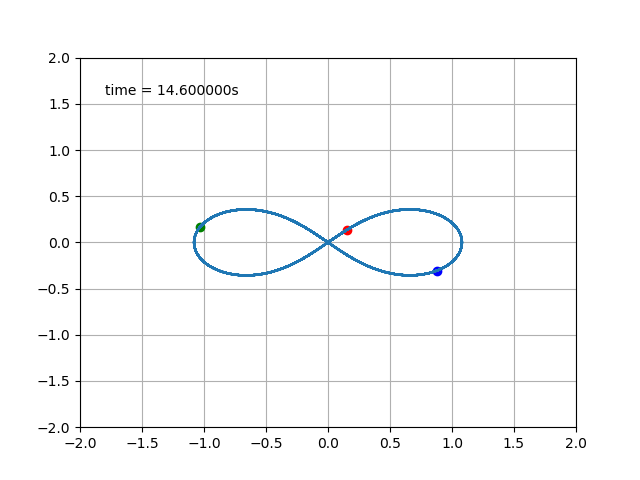

In [18]:
G = 1
mA = 1
mB = 1
mC = 1

# create a time array
dt = 0.1 # seconds
time_interval = np.arange(0.0, 200.0, dt)

# state with 12 elements of satellite motion: (x, v_x, y, v_y) * 3 bodies
state = (0.97000436, 0.93240737/2, -0.24308753, 0.86473146/2,
         -0.97000436, 0.93240737/2, 0.24308753, 0.86473146/2,
         0.0, -0.93240737, 0.0, -0.86473146)

object_positions = integrate.odeint(derivs, state, time_interval)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2., 2.), ylim=(-2., 2.))
ax.grid()

markerA, = ax.plot([], [], 'ro-')
markerB, = ax.plot([], [], 'bo-')
markerC, = ax.plot([], [], 'go-')
time_template = 'time = %fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    markerA.set_data([], [])
    markerB.set_data([], [])
    markerC.set_data([], [])
    time_text.set_text('')
    return markerA, markerB, markerC, time_text

def animate(i):
    markerA.set_data(object_positions[i,0], object_positions[i,2])
    markerB.set_data(object_positions[i,4], object_positions[i,6])
    markerC.set_data(object_positions[i,8], object_positions[i,10])
    time_text.set_text(time_template % (i*dt))
    return markerA, markerB, markerC, time_text

ax.plot(object_positions[:,0], object_positions[:,2])
ani = animation.FuncAnimation(fig, animate, np.arange(1, len(time_interval)),
                                         interval=200, blit=True, init_func=init)

## (c) Stability of 3-body Orbit

We check the stability by modifying the initial conditions in a symmetric way.  That is, if we change $x_A$ by 1%, we change $x_B$ by the same fraction.

<IPython.core.display.Javascript object>


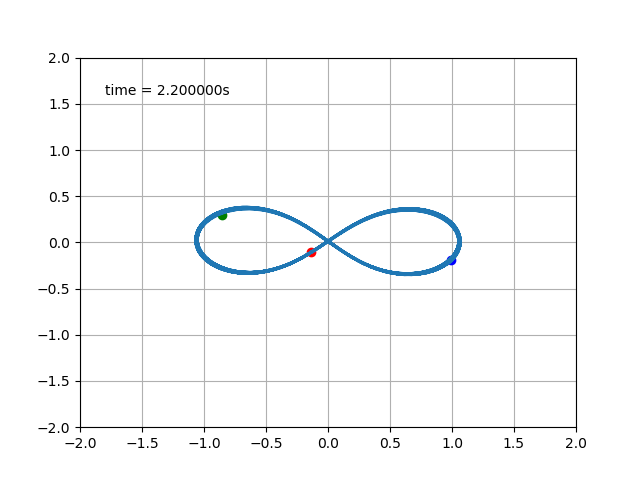

In [20]:
state = (0.96000436, 0.93240737/2, -0.24308753, 0.86473146/2,
         -0.96000436, 0.93240737/2, 0.24308753, 0.86473146/2,
         0.0, -0.93240737, 0.0, -0.86473146)

object_positions = integrate.odeint(derivs, state, time_interval)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2., 2.), ylim=(-2., 2.))
ax.grid()

markerA, = ax.plot([], [], 'ro-')
markerB, = ax.plot([], [], 'bo-')
markerC, = ax.plot([], [], 'go-')
time_template = 'time = %fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    markerA.set_data([], [])
    markerB.set_data([], [])
    markerC.set_data([], [])
    time_text.set_text('')
    return markerA, markerB, markerC, time_text

def animate(i):
    markerA.set_data(object_positions[i,0], object_positions[i,2])
    markerB.set_data(object_positions[i,4], object_positions[i,6])
    markerC.set_data(object_positions[i,8], object_positions[i,10])
    time_text.set_text(time_template % (i*dt))
    return markerA, markerB, markerC, time_text

ax.plot(object_positions[:,0], object_positions[:,2])
ani = animation.FuncAnimation(fig, animate, np.arange(1, len(time_interval)),
                                         interval=200, blit=True, init_func=init)

The result is not completely stable, but it changes very slowly.  The figure eight pattern remains, but its width increases slightly.
If the initial conditions are changed by more than about 2%, then the stable orbit breaks down.  (Try it!)

# Problem 3

The differential equation for the string is 

$$\frac{1}{y} \frac{T}{\mu} \frac{d^2 y}{dx^2} = \frac{1}{\tau} \frac{d^2 \tau}{dt^2}$$

with the separated solutions $y(x)$ and $\tau(t)$.

## (a) Spatial Solution

If the separation constant is taken to be $-\omega^2$, then the spatial equation is 

$$\begin{align}
\frac{1}{y} \frac{T}{\mu} \frac{d^2 y}{dx^2} &= - \omega^2 \\
\frac{d^2 y}{dx^2} +\frac{\omega^2 \mu}{T} y &= 0 
\end{align}$$

Now, if $\mu(x) = \mu_0$ (a constant), the solution to this equation is just the harmonic functions

$$y(x) = \alpha \sin\left(\omega \sqrt{\frac{\mu_0}{T}} x \right) + \beta \cos\left( \omega \sqrt{\frac{\mu_0}{T}} x \right)$$

## (b) Solving for $\omega$

The boundary conditions are $y(0)=0$ and $y(L)=0$.

Because $y(0)=0$, we must have $\beta=0$.  And because $y(L)=0$, we must have 

$$\begin{align}
\omega \sqrt{\frac{\mu_0}{T}} L &= n\pi \\
\omega &= \frac{n\pi}{L}\sqrt{\frac{T}{\mu}}
\end{align}$$

This is the analytic result.  Now let's compare it with the numerical result, which we turn to next.

## (c) Fundamental Frequency

The differential equation is 

$$\begin{cases}
\frac{d^2 y}{dx^2} -\frac{\omega^2 \mu}{T} y = 0 \\
y(0) = 0 \\
y(L) = 0
\end{cases}$$

Use two variables, $y$ and $\dot y = dy/dx$, to write two first-order equations.  

$$\begin{align}
\frac{dy}{dx} &= \dot y \\
\frac{d\dot y}{dx} &= -\frac{\omega^2 \mu}{T} y
\end{align}$$

The shooting method guesses a value for $\omega$, evolves it forward (in $x$, not $t$), and checks to see if that $\omega$ satisfies the boundary conditions.
We do not even have to make an intelligent guess for the initial state $(y,\dot y)$.  The "initial" $\dot y$ (at $x=0$) does not affect the frequency at all, but it does affect the amplitude of the solution.

old ω = 1000.0 , old φ = 1.0 , ω = 2000.0 , old φ = 0.5 , β = 0.0
old ω = 2000.0 , old φ = 0.5 , ω = 3000.0 , old φ = 0.07161104294074302 , β = 0.0
old ω = 3000.0 , old φ = 0.07161104294074302 , ω = 3167.163606252431 , old φ = 0.015553066452557981 , β = 0.0
old ω = 3167.163606252431 , old φ = 0.015553066452557981 , ω = 3213.5424953841366 , old φ = 0.0009021934980958032 , β = 0.0


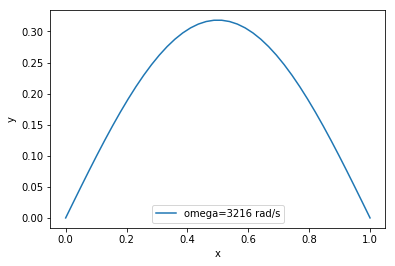

In [27]:
% matplotlib inline

import scipy.integrate

L = 1. # meters
m = 0.954 / 1000. # kilograms
T = 1000. # Newtons

beta = 0. # boundary condition at end of string
omega = 2000. # initial test value, could be anything
previous_omega = 1000.
previous_phi = 1.

def mu(x):
    # constant linear mass density
    return m/L

def derivs(state, x):
    out = np.zeros_like(state)
    out[0] = state[1]
    out[1] = -pow(omega,2) * mu(x) * state[0] / T
    return out

N = 40
(x_values, x_interval) = np.linspace(0., L, N, retstep=True)

phi = 0.5 # initial test value for phi boundary condition (omega) at end of string
while (abs(beta - phi) > 0.0001):
    print("old ω =", previous_omega, ", old φ =", previous_phi, ", ω =", omega, ", old φ =", phi, ", β =", beta)
    omega2 = omega
    omega1 = previous_omega
    phi2 = phi
    phi1 = previous_phi
    omega3 = omega2 + (beta-phi2)*(omega2-omega1)/(phi2-phi1)
    omega = omega3
    state = (0., 1.)
    final_state = scipy.integrate.odeint(derivs, state, x_values)
    
    previous_omega = omega2
    previous_phi = phi2
    phi = final_state[-1, 0]
    
y_values = final_state[:,0]

plt.plot(x_values, y_values, label='omega=%.0f rad/s' % omega)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

This approach converges very quickly.
The exact analytic solution from part (b) gave $\omega = 3216$ rad/s for the lowest ($n=1$) angular frequency.

## (d) Non-Uniform Mass Density

With a non-uniform $\mu(x)$, the differential equation still holds, but we do not expect simple harmonic eigenfunctions.

$$\mu(x) = 0.954\,\text{g/m} + \left(x-\frac{L}{2}\right) 0.8\,\text{g/m}$$

We use the same code but modify the `mu(x)` function.

old ω = 1000.0 , old φ = 1.0 , ω = 2000.0 , old φ = 0.5 , β = 0.0
old ω = 2000.0 , old φ = 0.5 , ω = 3000.0 , old φ = 0.06849250674706855 , β = 0.0
old ω = 3000.0 , old φ = 0.06849250674706855 , ω = 3158.7284295592085 , old φ = 0.014642792889084613 , β = 0.0
old ω = 3158.7284295592085 , old φ = 0.014642792889084613 , ω = 3201.889801331299 , old φ = 0.0007858664976627024 , β = 0.0


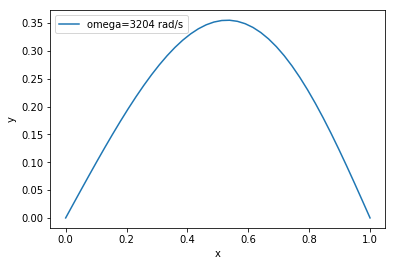

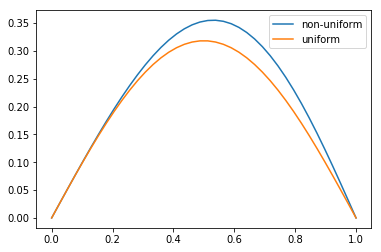

In [31]:
import scipy.integrate

L = 1. # meters
T = 1000. # Newtons

beta = 0. # boundary condition at end of string
omega = 2000. # initial test value
previous_omega = 1000.
previous_phi = 1.

def mu(x):
    return 1./1000. * (0.954 + (x-L/2.)*0.8)

def derivs(state, x):
    out = np.zeros_like(state)
    out[0] = state[1]
    out[1] = -pow(omega,2) * mu(x) * state[0] / T
    return out

(x_values, x_interval) = np.linspace(0., L, N, retstep=True)

phi = 0.5 # initial test value for phi boundary condition (omega) at end of string
while (abs(beta - phi) > 0.0001):
    print("old ω =", previous_omega, ", old φ =", previous_phi, ", ω =", omega, ", old φ =", phi, ", β =", beta)
    omega2 = omega
    omega1 = previous_omega
    phi2 = phi
    phi1 = previous_phi
    omega3 = omega2 + (beta-phi2)*(omega2-omega1)/(phi2-phi1)
    omega = omega3
    state = (0., 1.)
    final_state = scipy.integrate.odeint(derivs, state, x_values)
    
    previous_omega = omega2
    previous_phi = phi2
    phi = final_state[-1, 0]
    

y_values_nonuniform = final_state[:,0]

plt.plot(x_values, y_values_nonuniform, label='omega=%.0f rad/s' % omega)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

plt.plot(x_values, y_values_nonuniform, label='non-uniform')
plt.plot(x_values, y_values, label='uniform')
plt.legend()
plt.show()

The eigenfunction is shifted toward higher $x$ because of the change in the mass density.  
The frequency is shifted slightly lower because it is harder to move the heavier part of the string.
The size of the shift here is not large: 12 rad/s = 1.9 Hz.

It is interesting to play with the coefficient 0.8 in the `mu(x)` function and see how that changes the eigenfunction.